# TensorFlow 基礎


## Tensors

TensorFlow 多維陣列或張量tf.Tensor進行操作。這是一個二維張量

In [2]:
import tensorflow as tf

x = tf.constant([[1., 2., 3.],
                 [4., 5., 6.]])

print(x)
print(x.shape)
print(x.dtype)

tf.Tensor(
[[1. 2. 3.]
 [4. 5. 6.]], shape=(2, 3), dtype=float32)
(2, 3)
<dtype: 'float32'>


最重要的屬性tf.Tensor是它的shape和dtype：

* `Tensor.shape`：告訴您張量沿每個軸的大小。
* `Tensor.dtype`：告訴你張量中所有元素的類型。


TensorFlow 對張量實現標準數學運算，以及許多專門用於機器學習的運算

In [3]:
x + x

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[ 2.,  4.,  6.],
       [ 8., 10., 12.]], dtype=float32)>

In [4]:
5 * x

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[ 5., 10., 15.],
       [20., 25., 30.]], dtype=float32)>

In [5]:
x @ tf.transpose(x)

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[14., 32.],
       [32., 77.]], dtype=float32)>

In [6]:
tf.concat([x, x, x], axis=0)

<tf.Tensor: shape=(6, 3), dtype=float32, numpy=
array([[1., 2., 3.],
       [4., 5., 6.],
       [1., 2., 3.],
       [4., 5., 6.],
       [1., 2., 3.],
       [4., 5., 6.]], dtype=float32)>

In [7]:
tf.nn.softmax(x, axis=-1)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.09003057, 0.24472848, 0.6652409 ],
       [0.09003057, 0.24472848, 0.6652409 ]], dtype=float32)>

In [8]:
tf.reduce_sum(x)

<tf.Tensor: shape=(), dtype=float32, numpy=21.0>

Note: 注意：通常，在 TensorFlow 函數需要`Tensor`作為輸入的任何地方，該函數還將接受任何可以`Tensor`使用轉換為`a`的內容`tf.convert_to_tensor`。請參閱下面。

In [9]:
tf.convert_to_tensor([1,2,3])

<tf.Tensor: shape=(3,), dtype=int32, numpy=array([1, 2, 3])>

In [10]:
tf.reduce_sum([1,2,3])

<tf.Tensor: shape=(), dtype=int32, numpy=6>

使用GPU加速

In [11]:
if tf.config.list_physical_devices('GPU'):
  print("TensorFlow **IS** using the GPU")
else:
  print("TensorFlow **IS NOT** using the GPU")

TensorFlow **IS** using the GPU


## 變數

一般`tf.Tensor`無法改變。要放可改變的資料(如模型的參數)必須使用`tf.Variable`。

In [12]:
var = tf.Variable([0.0, 0.0, 0.0])

In [13]:
var.assign([1, 2, 3])

<tf.Variable 'UnreadVariable' shape=(3,) dtype=float32, numpy=array([1., 2., 3.], dtype=float32)>

In [14]:
var.assign_add([1, 1, 1])

<tf.Variable 'UnreadVariable' shape=(3,) dtype=float32, numpy=array([2., 3., 4.], dtype=float32)>

## 自動微分

可以使用自動微分來完成梯度下降。TensorFlow 實現了自動微分 (autodiff)，它使用微積分來計算梯度。用來計算模型的誤差或損失相對於其權重的梯度。

In [15]:
x = tf.Variable(1.0)

def f(x):
  y = x**2 + 2*x - 5
  return y

In [16]:
f(x)

<tf.Tensor: shape=(), dtype=float32, numpy=-2.0>

在`x = 1.0`, `y = f(x) = (1**2 + 2*1 - 5) = -2`.

`y`的導數`y' = f'(x) = (2*x + 2) = 4`，可自動計算

In [17]:
with tf.GradientTape() as tape:
  y = f(x)

g_x = tape.gradient(y, x)  # g(x) = dy/dx

g_x

<tf.Tensor: shape=(), dtype=float32, numpy=4.0>

## 圖和tf.function
TensorFlow 還提供了以下工具：

* 性能優化：加速訓練和推理。
* 導出：這樣您就可以在完成訓練後儲存模型。
這些要求您將`tf.function`TensorFlow程式與 Python 分開。

In [18]:
@tf.function
def my_func(x):
  print('Tracing.\n')
  return tf.reduce_sum(x)

第一次運行時`tf.function`，雖然在Python中執行，但它會捕獲一個完整的、優化的圖，表示函式內完成的TensorFlow計算。

In [19]:
x = tf.constant([1, 2, 3])
my_func(x)

Tracing.



<tf.Tensor: shape=(), dtype=int32, numpy=6>

在後續呼叫TensorFlow僅執行優化後的圖，跳過任何非TensorFlow步驟。`my_func`不會列印Tracing，因為`print`是Python函式，而不是TensorFlow函式。

In [20]:
x = tf.constant([10, 9, 8])
my_func(x)

<tf.Tensor: shape=(), dtype=int32, numpy=27>

_signature_ (`shape`及`dtype`)不一樣的輸入會產生新的Graph

In [21]:
x = tf.constant([10.0, 9.1, 8.2], dtype=tf.float32)
my_func(x)

Tracing.



<tf.Tensor: shape=(), dtype=float32, numpy=27.3>

* 在許多情況下，它們可以加快執行速度
* 您可以使用 導出這些圖表，以便在伺服器或行動裝置動設備`tf.saved_model`等其他系統上運行，無需安裝 Python。

## Modules, layers,及models

`tf.Module`是一個用於管理tf.Variable物件以及`tf.function`進行操作的物件的類別。該類別`tf.Module`支援下面兩個重要功能
1. 使用儲存和恢復變數的值`tf.train.Checkpoint`。在訓練期間非常有用，可以快速儲存和恢復模型的狀態
2. 導入和導出`tf.Variable`值和圖表。獨立於建立模型的 Python 程式來運行模型。`tf.functiontf.saved_model`

In [22]:
class MyModule(tf.Module):
  def __init__(self, value):
    self.weight = tf.Variable(value)

  @tf.function
  def multiply(self, x):
    return x * self.weight

In [23]:
mod = MyModule(3)
mod.multiply(tf.constant([1, 2, 3]))

<tf.Tensor: shape=(3,), dtype=int32, numpy=array([3, 6, 9])>

儲存`Module`:

In [24]:
save_path = './saved'
tf.saved_model.save(mod, save_path)

INFO:tensorflow:Assets written to: ./saved\assets


可以載入儲存的model執行

In [25]:
reloaded = tf.saved_model.load(save_path)
reloaded.multiply(tf.constant([1, 2, 3]))

<tf.Tensor: shape=(3,), dtype=int32, numpy=array([3, 6, 9])>

以此為基礎的`tf.keras.layers.Layer`和`tf.keras.Model`類別就是從`tf.Module`建立的

## 訓練迴圈

建立一個模型來訓練

先建立一些資料，以x**2 + 2*x -5這個方程式為主，來建立附近的資料點，然後看從這些資料點能不能訓練一個模型來預測方程式

In [28]:
import matplotlib
from matplotlib import pyplot as plt

matplotlib.rcParams['figure.figsize'] = [9, 6]

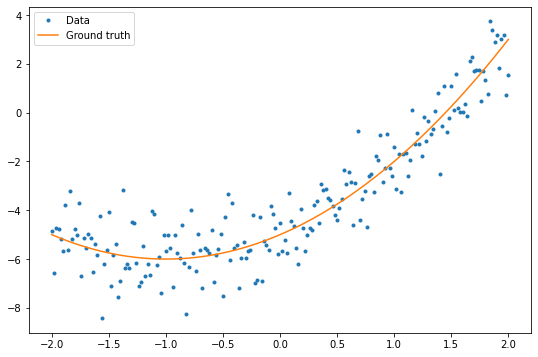

In [29]:
x = tf.linspace(-2, 2, 201)
x = tf.cast(x, tf.float32)

def f(x):
  y = x**2 + 2*x - 5
  return y

y = f(x) + tf.random.normal(shape=[201])

plt.plot(x.numpy(), y.numpy(), '.', label='Data')
plt.plot(x, f(x), label='Ground truth')
plt.legend();

建立具有隨機初始化權重和偏差的二次模型

In [30]:
class Model(tf.Module):

  def __init__(self):
    # Randomly generate weight and bias terms
    rand_init = tf.random.uniform(shape=[3], minval=0., maxval=5., seed=22)
    # Initialize model parameters
    self.w_q = tf.Variable(rand_init[0])
    self.w_l = tf.Variable(rand_init[1])
    self.b = tf.Variable(rand_init[2])
  
  @tf.function
  def __call__(self, x):
    # Quadratic Model : quadratic_weight * x^2 + linear_weight * x + bias
    return self.w_q * (x**2) + self.w_l * x + self.b

訓練前看表現如何

In [31]:
quad_model = Model()

In [32]:
def plot_preds(x, y, f, model, title):
  plt.figure()
  plt.plot(x, y, '.', label='Data')
  plt.plot(x, f(x), label='Ground truth')
  plt.plot(x, model(x), label='Predictions')
  plt.title(title)
  plt.legend()

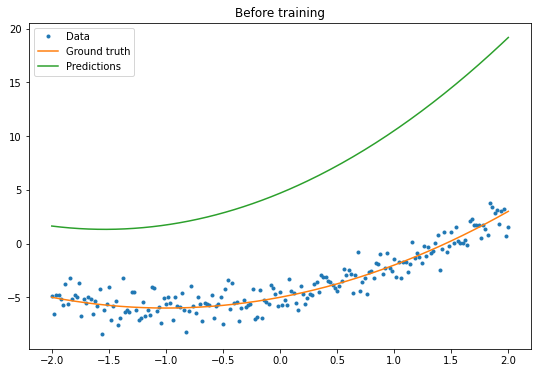

In [33]:
plot_preds(x, y, f, quad_model, 'Before training')

使用MSE作為損失函式，預測值為$\hat{y}$，真值為$y$

$MSE = \frac{1}{m}\sum_{i=1}^{m}(\hat{y}_i -y_i)^2$

In [34]:
def mse_loss(y_pred, y):
  return tf.reduce_mean(tf.square(y_pred - y))

基本訓練循環。該循環將利用 MSE 損失函數及其相對於輸入的梯度來迭代更新模型的參數。使用小批量進行訓練可以提高記憶體效率並加快收斂速度。該`tf.data.Dataset`API具有用於批次處理和shuffle

In [35]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices((x, y))
dataset = dataset.shuffle(buffer_size=x.shape[0]).batch(batch_size)

Mean squared error for step 0: 56.232
Mean squared error for step 10: 9.502
Mean squared error for step 20: 3.866
Mean squared error for step 30: 1.968
Mean squared error for step 40: 1.300
Mean squared error for step 50: 1.070
Mean squared error for step 60: 0.984
Mean squared error for step 70: 0.958
Mean squared error for step 80: 0.948
Mean squared error for step 90: 0.945




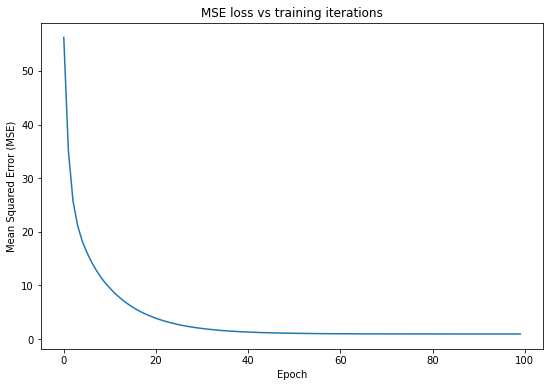

In [36]:
# Set training parameters
epochs = 100
learning_rate = 0.01
losses = []

# Format training loop
for epoch in range(epochs):
  for x_batch, y_batch in dataset:
    with tf.GradientTape() as tape:
      batch_loss = mse_loss(quad_model(x_batch), y_batch)
    # Update parameters with respect to the gradient calculations
    grads = tape.gradient(batch_loss, quad_model.variables)
    for g,v in zip(grads, quad_model.variables):
        v.assign_sub(learning_rate*g)
  # Keep track of model loss per epoch
  loss = mse_loss(quad_model(x), y)
  losses.append(loss)
  if epoch % 10 == 0:
    print(f'Mean squared error for step {epoch}: {loss.numpy():0.3f}')

# Plot model results
print("\n")
plt.plot(range(epochs), losses)
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error (MSE)")
plt.title('MSE loss vs training iterations');

訓練後

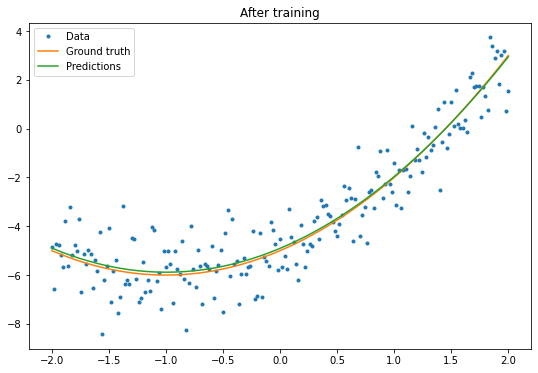

In [37]:
plot_preds(x, y, f, quad_model, 'After training')

用`tf.keras`可以做一模一樣的事

在Keras中建立序列模型`tf.keras.Sequential`，使用`tf.keras.layers.Dense`，作為特徵。lambda層`tf.keras.layers.Lambda`可以用來執行這種堆疊變換，以便學習非線性方程式$w_1x^2 + w_2x + b$。


In [48]:
new_model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.stack([x, x**2], axis=1)),
    tf.keras.layers.Dense(units=1, kernel_initializer=tf.random.normal)])

In [49]:
new_model.compile(
    loss=tf.keras.losses.MSE,
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01))

history = new_model.fit(x, y,
                        epochs=100,
                        batch_size=32,
                        verbose=0)

new_model.save('./my_new_model')

INFO:tensorflow:Assets written to: ./my_new_model\assets


Observe your Keras model's performance after training:

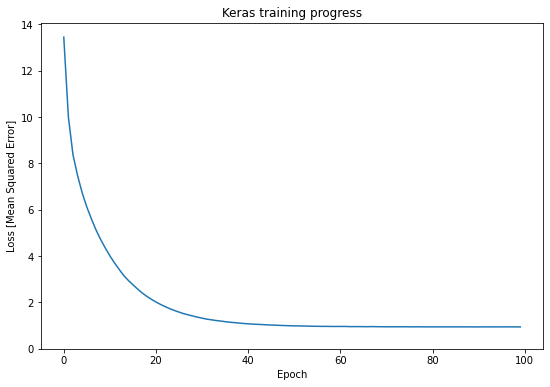

In [50]:
plt.plot(history.history['loss'])
plt.xlabel('Epoch')
plt.ylim([0, max(plt.ylim())])
plt.ylabel('Loss [Mean Squared Error]')
plt.title('Keras training progress');

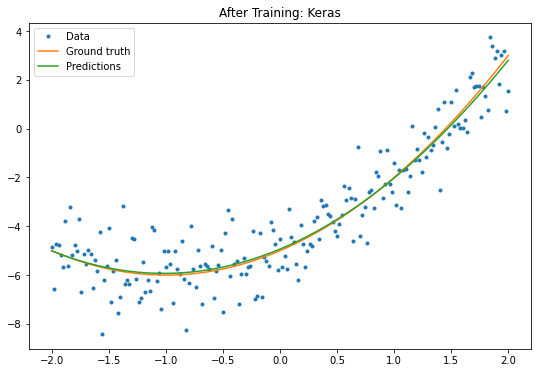

In [45]:
plot_preds(x, y, f, new_model, 'After Training: Keras')